In [1]:
from result_analysis import show_corrected_test_performance
import pandas as pd

In [2]:
algorithms = ['PL', 'STC', 'CC', 'HLNC', 'OBNC', 'BE']

experiments = ['phishing_having_IP_Address', 'bank_housing', 'monks1_attr3', 'biodeg_V25', 
                'credit_A1', 'sick_referral_source_other', 'vote_immigration', 'ads_local', 'churn_voice_mail_plan']

noise_types = ['random', 'flip', 'bias', 'balanced_bias']

In [3]:
pred_metrics = ['accuracy', 'roc_auc']

fair_metrics = [
        'auc_difference',
        'equal_opportunity_difference', 
        'predictive_equality_difference',
        'demographic_parity_difference',
        'equalized_odds_difference']

metrics = pred_metrics + fair_metrics

In [4]:
runs = {}
for noise_type in noise_types:
    runs[noise_type] = {}
    for exp in experiments:
        for alg in algorithms:
            runs[noise_type][f'{exp}_{alg}'] = pd.read_csv(f'../noiseinjection_results/{noise_type}/{exp}_{alg}.csv').fillna(0)

# runs = {}
# for exp in experiments:
#     for alg in algorithms:
#         runs[f'{exp}_{alg}'] = mlflow.search_runs(experiment_names=[f'{exp}_{alg}'], order_by=['start_time DESC']).fillna(0)
#         runs[f'{exp}_{alg}'].to_csv(f'noiseinjection_results/{run}.csv', index=False)


# Random noise

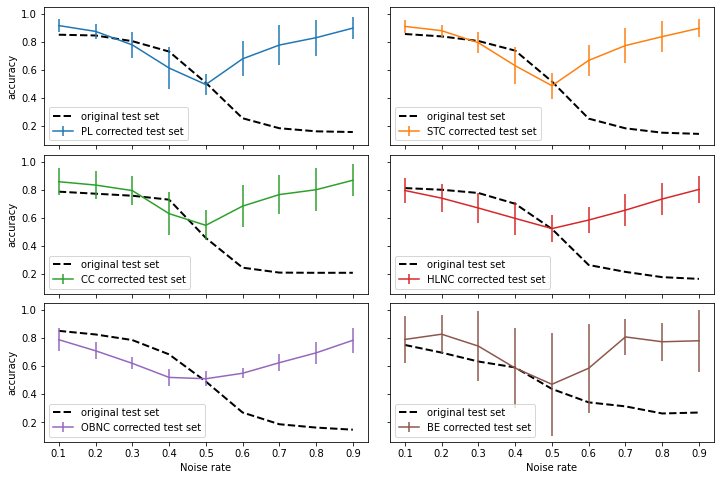

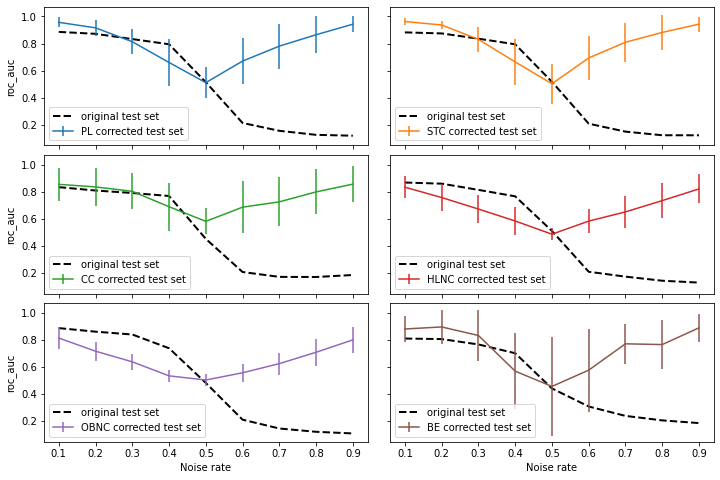

In [5]:
for metric in pred_metrics:
    show_corrected_test_performance('random', metric, algorithms, experiments, runs)

# Group-dependant noise

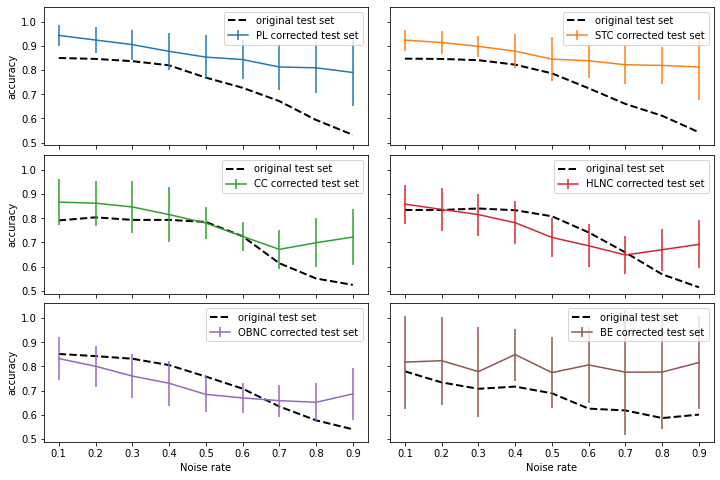

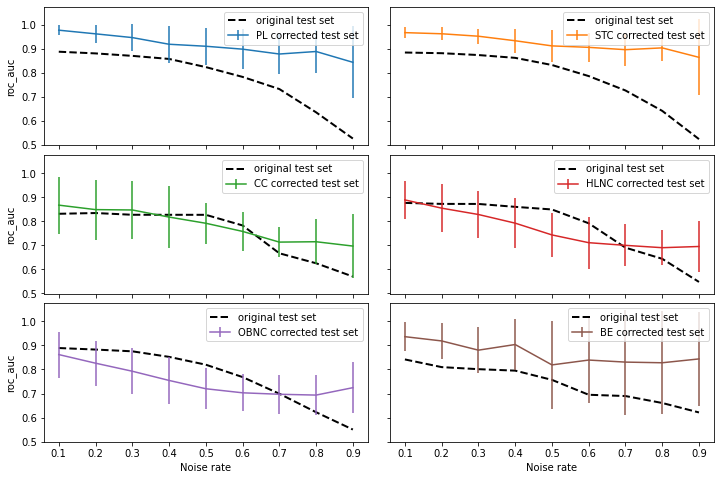

In [6]:
for metric in pred_metrics:
    show_corrected_test_performance('flip', metric, algorithms, experiments, runs)

# Positive bias noise

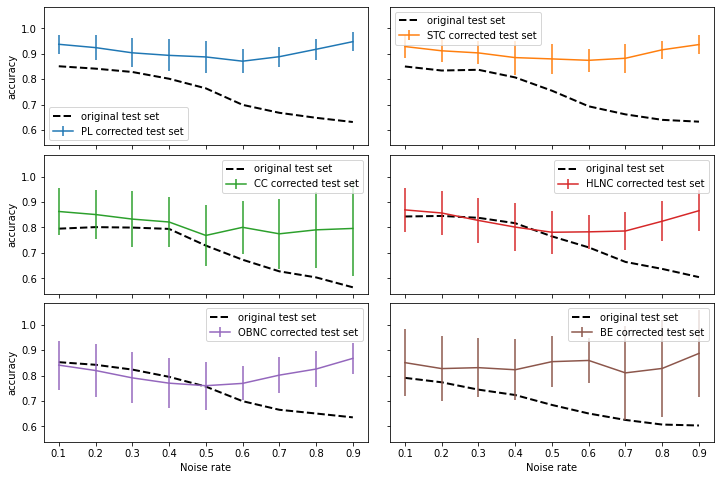

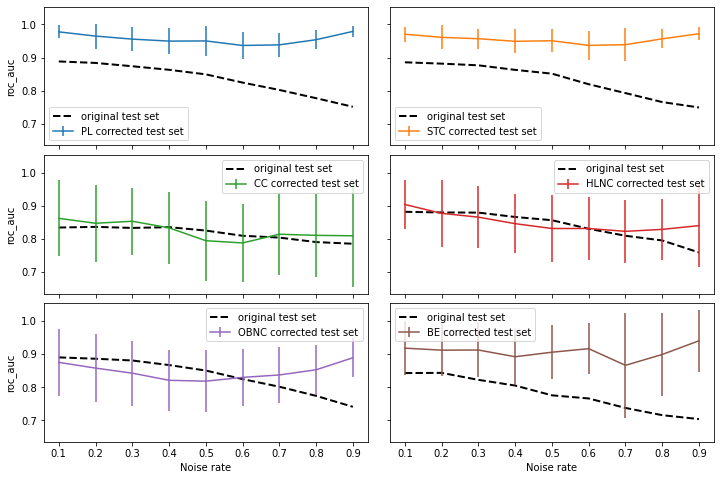

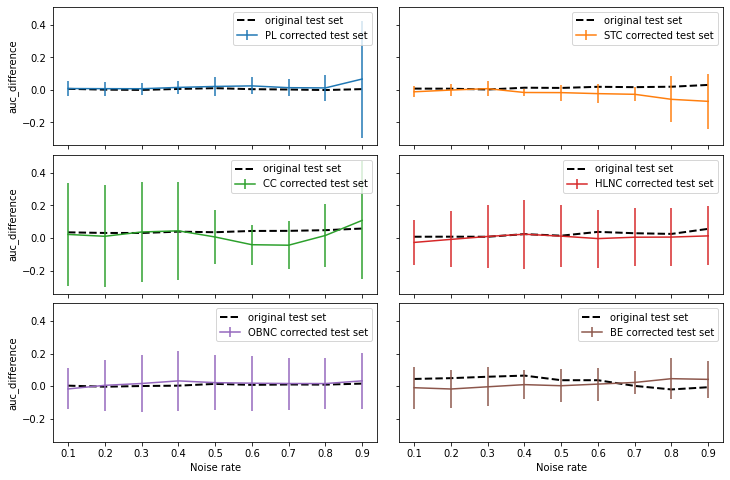

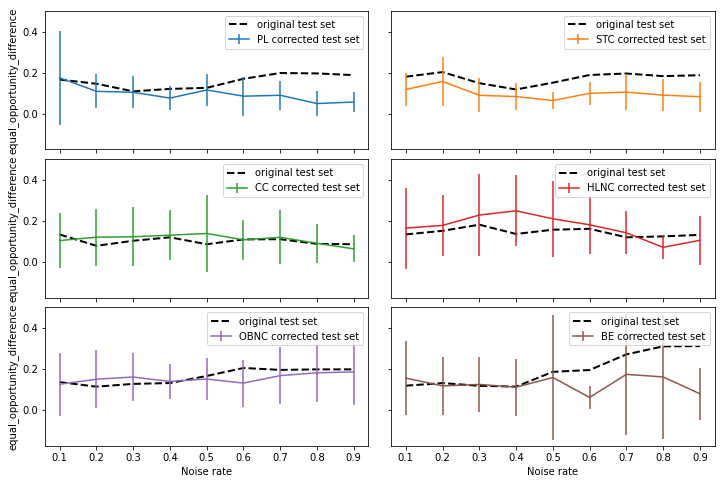

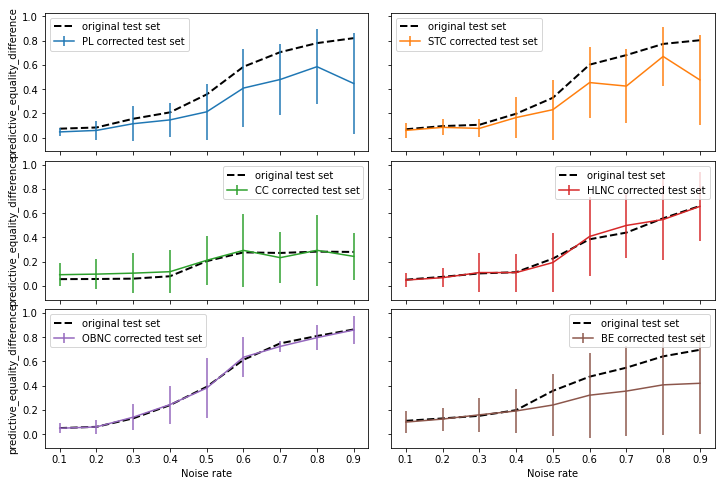

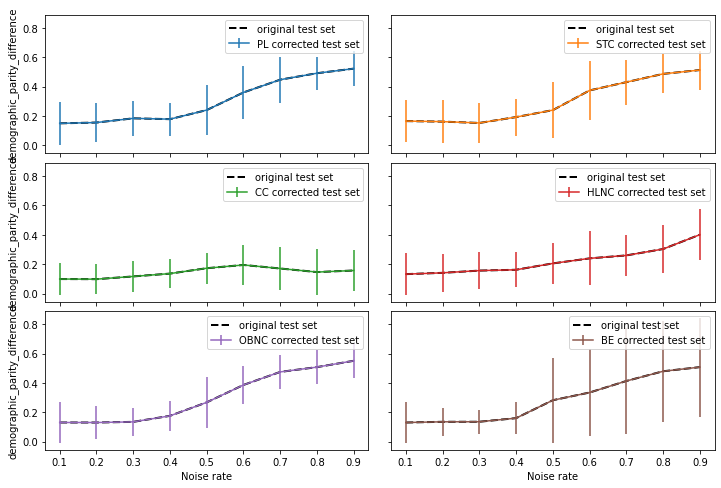

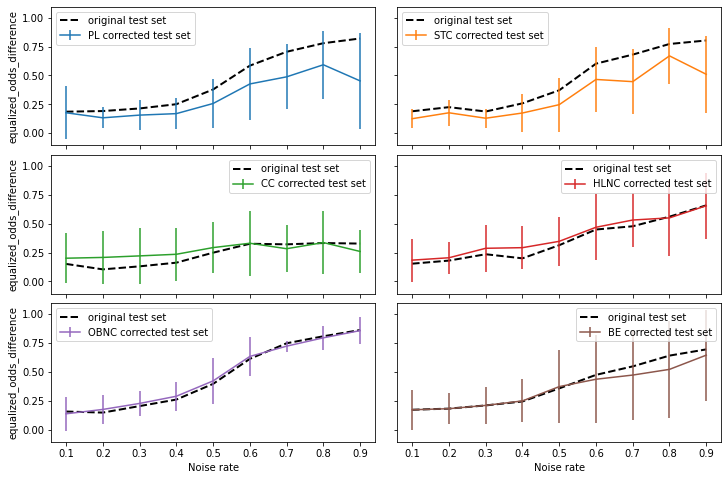

In [7]:
for metric in metrics:
    show_corrected_test_performance('bias', metric, algorithms, experiments, runs)

# Balanced bias noise

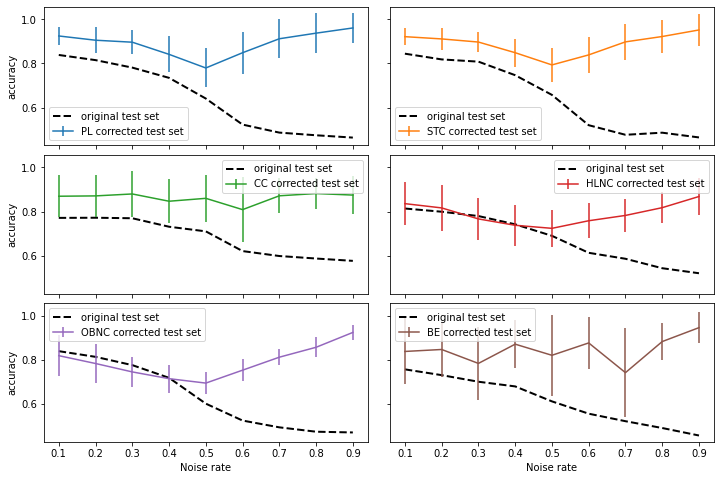

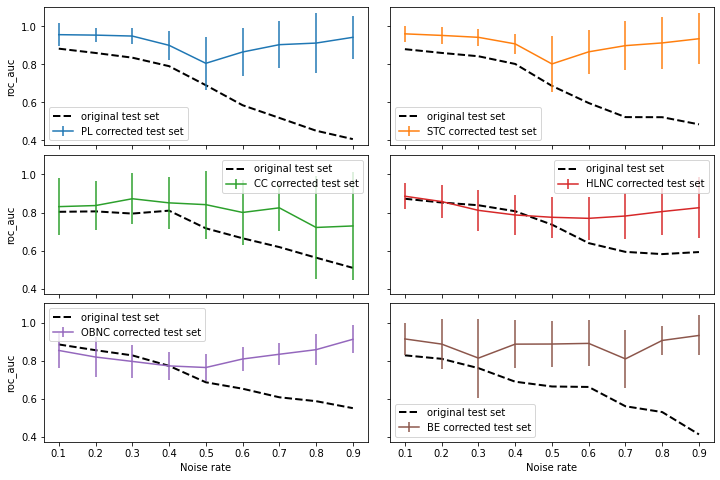

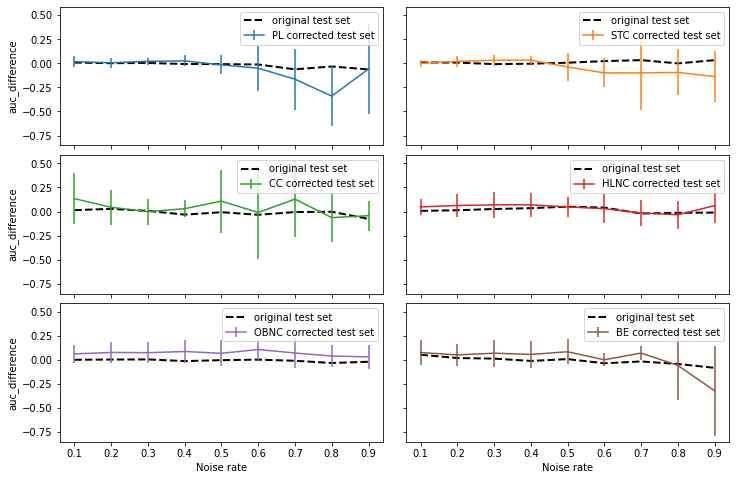

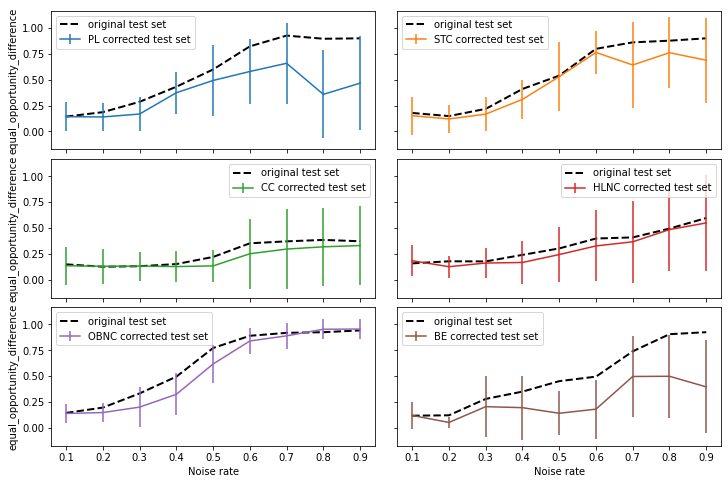

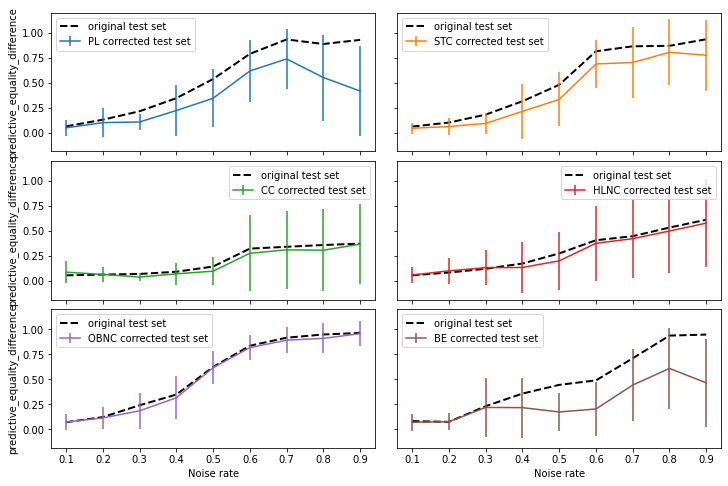

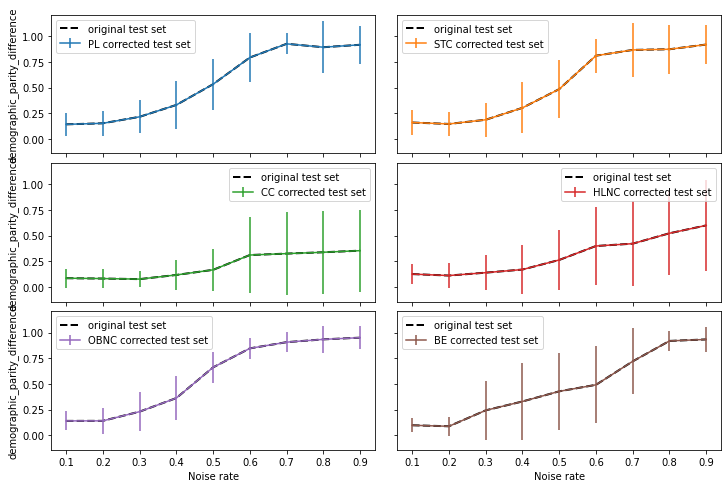

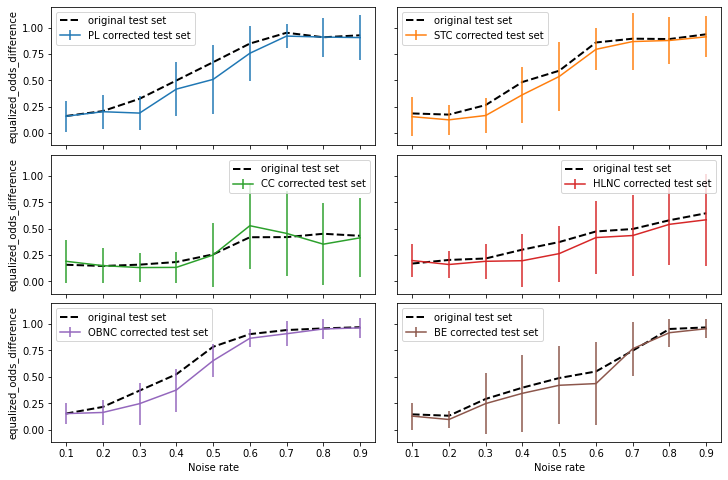

In [8]:
for metric in metrics:
    show_corrected_test_performance('balanced_bias', metric, algorithms, experiments, runs)